## **Week 1: Bag of Visual Words Framework for Image Classification**

_performed by Team 4: Advait Dixit, Albert Barreiro, Ayan Banerjee_

### **Table of Contents**

*   [1. Library](#libraries): Installing and loading necessary libraries in order to complete the project.
*   [2. Dataset](#dataset): : In this stage we have load the dataset and visualize to understand the problem.
*   [3. Keypoint and Descriptors](#kpd): Here we have been tested various local descriptors namely SIFT (both vanilla and dense), SURF, DAISY, AKAZE and BRISK to find the best descriptor to proceed.
*   [4. Spatial Pyramids](#kpd): Here we compute the keypoints and descriptors at different pyramid levels to efficiently aggregates the local features.
*   [5. Clustering](#kmeans): Here, we have tried two clustering method minibatchKMeans and K-Medoids to prepare our optimal codebook.
*   [6. Classifiers](#cls): This section is dedicated to implemented the K-nearest neighbour and logistic regression.
    *   [6.1 KNN-Classifiers](#knn): Here we play with distance metric and number of neighbours to get optimum performance.
    *   [6.2 Logistic Regression](#logreg): Here we are eager to fined optimum coefficient by maximum likelihood estimation.
*   [7. Dimensionality Reduction](#dr): Helps to reduce dimension to get maximum separability between classes.
    *   [7.1 Principal Component Analysis](#pca): To improve the interpretability by fine-tune the PCA percentage and PCA components.
    *   [7.2 Linear Discriminant Analysis](#lda): To obtain maximum separability by finetune the lda components.
*   [8. Cross Validation](#cv): Cross-validate the system to find the overall training performance.
* [9. Test Validation](#tv): Test the defined system with unknown sets of data.
* [10. Visualization of Results](#roc): Getting ROC curve, deeper understanding about misclassfied samples and finding a reason why they misclassify.

### **1. Library** <a id="libraries"></a>

>   Note: In order to complete this project we need to install the following packages:
>   1.  **OpenCV:** It is a library of programming functions to deal with images.
>   2.  **Scikit-image:** It is an open source image processing library.
>   3.  **Pandas:** An open source library for data manipulation and analysis.
>   4.  **seaborn:** Data Visualization Library

First step to import the required libraries.

In [1]:
import cv2
import numpy as np
import pickle

from sklearn.cluster import MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import cross_validate
from sklearn.metrics import *
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
import pandas as pd


from PIL import Image

from skimage.feature import daisy
import matplotlib.pyplot as plt

import seaborn as sns

### **2. Dataset** <a id="dataset"></a>

Let us first read the train and test files

In [2]:
train_images_filenames = pickle.load(open('./MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('./MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['.' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['.' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('./MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('./MIT_split/test_labels.dat','rb'))

In [3]:
print("No. of training images:", len(train_images_filenames))
print("No. of testing images:", len(test_images_filenames))

No. of training images: 1881
No. of testing images: 807


Now, let us write a simple function to visualize the dataset for getting more insights

In [4]:
def visualize_datasets(img_fn, labels, samp_per_class=3):
    """
    Visualize the sample images from each class of the dataset.
    """
    #get unique classes
    classes = np.unique(np.array(labels))
    num_cls = len(classes)

    #plot the image from each class
    plt.figure(figsize=(20, 8))

    for y, cls in enumerate(classes):
        id = np.flatnonzero(np.array(labels) == cls)
        idxs = np.random.choice(id, samp_per_class, replace = False)
        for i, idx in enumerate(idxs):
            plt_id = i * num_cls + y +1
            plt.subplot(samp_per_class, num_cls, plt_id)
            plt.imshow(Image.open(img_fn[idx]))
            plt.axis('off')

            if(i == 0):
                plt.title(f'{cls} ({len(id)})')
    plt.show()

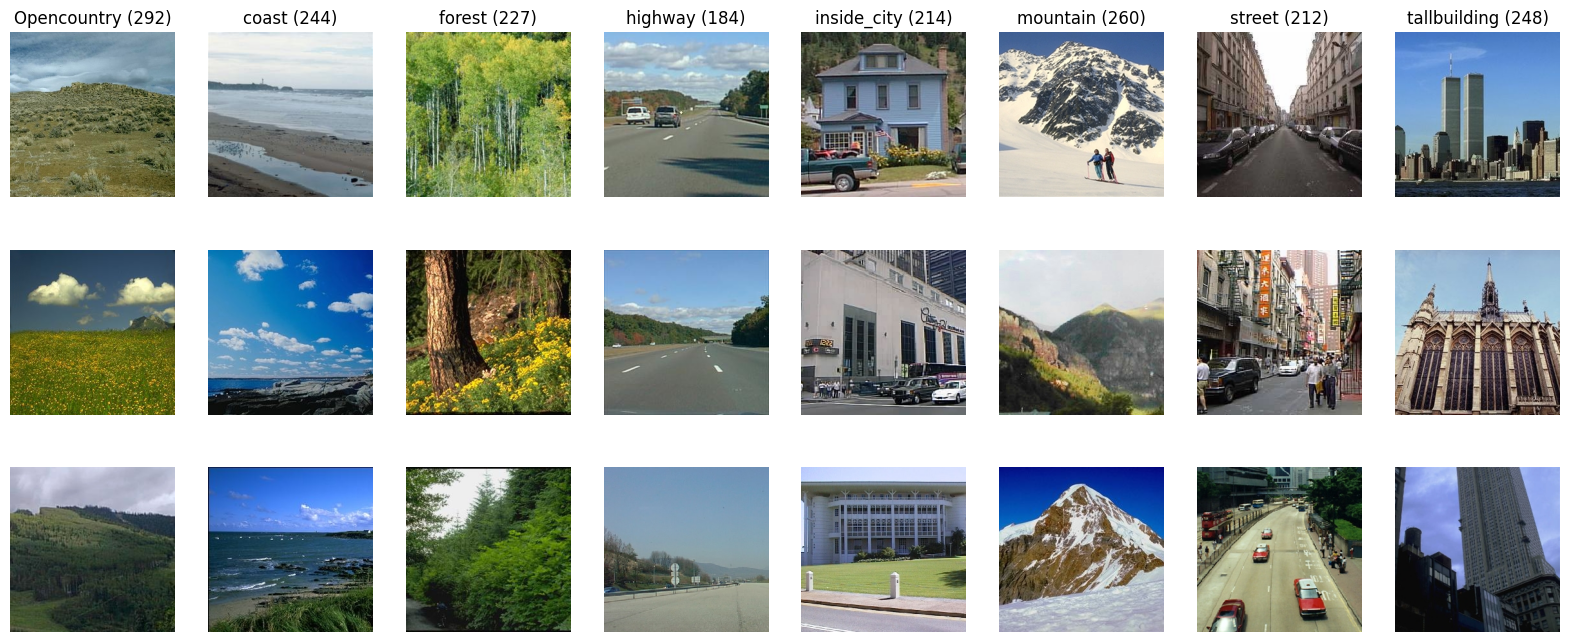

In [5]:
#Let's observe the training dataset
visualize_datasets(train_images_filenames, train_labels, 3)

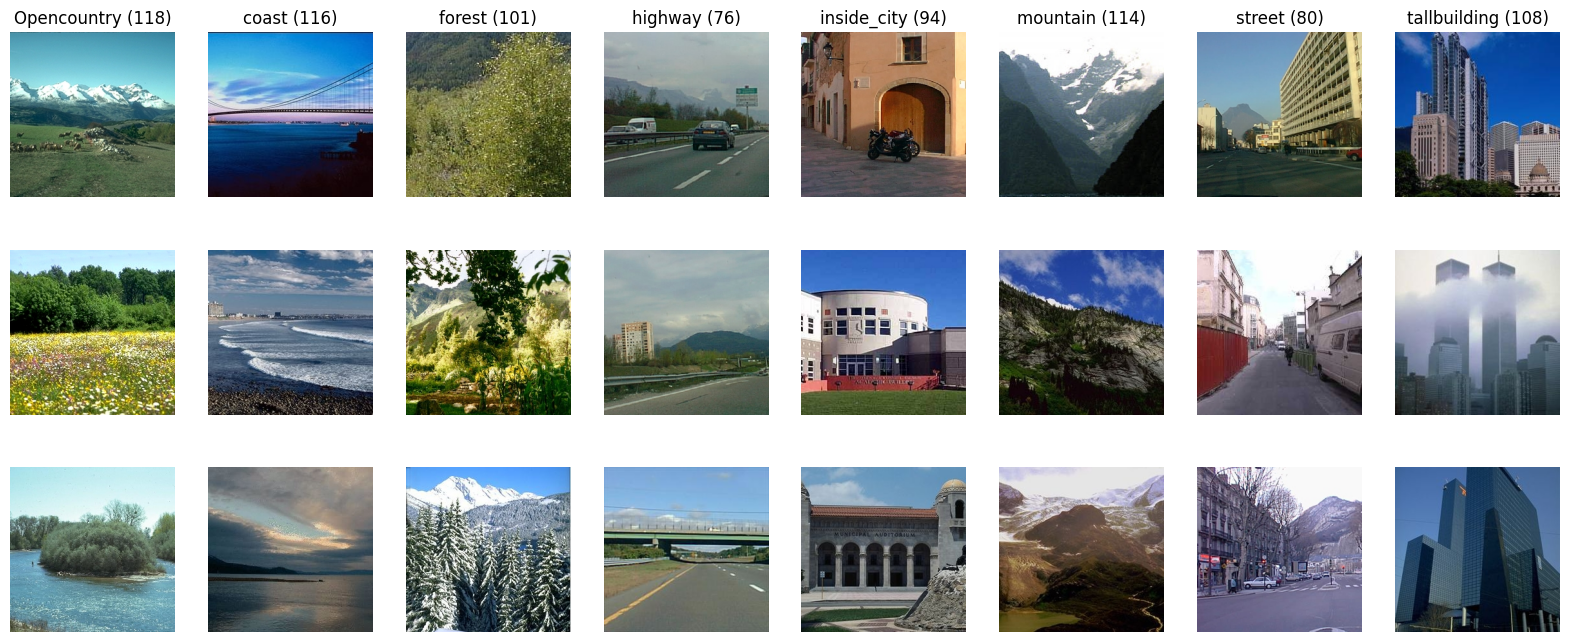

In [6]:
#for the testing dataset
visualize_datasets(test_images_filenames, test_labels, 3)

>   So, our dataset has eight distinct classes with 1881 training images and 807 testing images. Each of the class have on an average of 235 training images and 100 testing images respectively.

### **3. Keypoint and Descriptors** <a id="kpd"></a>

Let's start by visualizing the keypoints of each type of descriptor on a sample image

In [7]:
def show_keypoints(img_path, descriptor1=None, descriptor2=None, descriptor3=None, descriptor4=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kp1 = descriptor1.detect(gray)
        kp2 = descriptor2.detect(gray)
        kp3 = descriptor3.detect(gray)
        kp4 = descriptor4.detect(gray)
    else:
        kp = kps

    kp_img1 = cv2.drawKeypoints(img, kp1, gray)
    kp_img2 = cv2.drawKeypoints(img, kp2, gray)
    kp_img3 = cv2.drawKeypoints(img, kp3, gray)
    kp_img4 = cv2.drawKeypoints(img, kp4, gray)
    
    fig,axes = plt.subplots(1,5, figsize=(10, 5))
    titles = ['Original_image',f'SIFT-Keypoints:{len(kp1)}', f'BRISK-Keypoints:{len(kp2)}', f'AKAZE-Keypoints:{len(kp3)}', f'SURF-Keypoints:{len(kp4)}']
    images = [img, kp_img1, kp_img2, kp_img3, kp_img4]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
#let's take a random sample image
sample = train_images_filenames[25]

#creating the descriptors
sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
brisk = cv2.BRISK_create()
akaze = cv2.AKAZE_create()

#visualizing keypoints
show_keypoints(sample,sift,brisk,akaze, surf)

#### **Generate Descriptor**

This step help us to detect the keypoints and compute the descriptors using SIFT, BRISK, and AKAZE

In [9]:
img = cv2.imread(sample)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#SIFT
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures = 500)
_, sift_descriptor = SIFTdetector.detectAndCompute(gray, None)

#SURF
SURFdetector = cv2.xfeatures2d.SURF_create(hessianThreshold = 60)
_, SURF_descriptor = SURFdetector.detectAndCompute(gray, None)

#BRISK
BRISKdetector = cv2.BRISK_create(thresh=600)
_, brisk_descriptor = BRISKdetector.detectAndCompute(gray, None)

#AKAZE
AKAZEdetector = cv2.AKAZE_create()
_, brisk_descriptor = AKAZEdetector.detectAndCompute(gray, None)

#### **Tuning SIFT, SURF and BRISK parameters**

We compute the accuracy, average precision, recall and f1-score with 10 (stratified) fold cross-validation to tune the following parameters:

*   nfeatures of SIFT
*   hessianThreshold of SURF
*   threshhold of BRISK

In these cases, we consider the codebook size = 256 and we use KNN-Classifier with K=5 and cosine distance.

>   NOTE: The scripts we used for gridesearch are provided along with the notebook in our [Github](https://github.com/ayanban011/mcv-m3). Moreover, we use the following function 'plot_metrics' to visualize the results.

In [10]:
def plot_metrics(pd_data, param):
    """
    Utility function to plot accuracy, precision, recall, and f1-score
    """
    fig, axes = plt.subplots(1,4, figsize=(20,8), sharex=True)
    titles = ['Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']
    ylabels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    ymax = pd_data[titles].max().max()
    ymin = pd_data[titles].min().min()
    
    max_index = pd_data.groupby(param)['Cross-val f1'].idxmax() # get the max f1 of every posible value of the param  
    # get the rows with the max values using the index
    max_rows = pd_data.loc[max_index]


    for ax, title, ylabel in zip(axes.flatten(), titles, ylabels):
        ax.grid(True)
        ax.scatter(max_rows[param], max_rows[title])
        ax.set(xlabel=param, ylabel=ylabel, ylim=(ymin*0.99, ymax*1.01))
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

#### **SIFT: Finding the best number of features**

In [11]:
sift_opt_gs = pd.read_csv('./optimize_sift-2.csv', index_col = False)
plot_metrics(sift_opt_gs, 'NFeatures')

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/1760057806.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  sift_opt_gs = pd.read_csv('./optimize_sift-2.csv', index_col = False)


#### **SURF: Finding the best hessianThreshold**

In [12]:
surf_opt_gs = pd.read_csv('./optimize_surf-3.csv', index_col = False)
plot_metrics(surf_opt_gs,'hessianThresholds')

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/2440775564.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  surf_opt_gs = pd.read_csv('./optimize_surf-3.csv', index_col = False)


#### **BRISK: Finding the best Threshold**

In [13]:
brisk_opt_gs = pd.read_csv('./optimize_brisk.csv', index_col=False)
plot_metrics(brisk_opt_gs, 'threshold')

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/3957192687.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  brisk_opt_gs = pd.read_csv('./optimize_brisk.csv', index_col=False)


### **Conclusion of this experiments:**

*   **SIFT:** The performance will increase with the number of features upto a certain point, after which its either decrease or saturated (i.e. no further improvement). Although the bigger no. of features of the image, the more representative are the descriptors which may improve the classification performance. But if the features are not relevant to the classification its decrease the performance too. For this experiment we choose **Nfeatures = 1500**.

*   **SURF:** Here, the threshold determines how large the ouput from the hessian filter must be in order for a point to be used as an keypoint. So, a larger value will result in fewer keypoints which reduce the classification performance. We choose the **hessianThreshold = 15.**

*   **BRISK:** It is also similar to surf hence higher threshold reduce the classification performance. We choose **threshold = 0** which means that this parameter is not useful to our experiment.

#### **Making the descriptor denser will make an effect??**

Here, we will going to deal with dense descriptor like SIFT, SURF and DAISY. In order to implement it, we create a grid of spatially equidistant keypoints. This is configured with the 'step size' parameter.

In the next plots we show the effect of the step size in dense SIFT and dense DAISY.

#### The dense SIFT descriptor

In [14]:
def show_keypoints_dense(img_path, descriptor=None, kps=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if kps is None:
        kps = [descriptor.detect(gray)]
    kp_imgs = []
    for kp in kps:
        kp_imgs.append(cv2.drawKeypoints(img, kp, gray))
    
    fig,axes = plt.subplots(1,len(kps)+1, figsize=(4+len(kps)*2,8))
    
    titles = ['Original_image'] + [f'Keypoints:{len(kp)}' for kp in kps]
    images = [img] + kp_imgs
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
# To create dense keypoints
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]

# Dense SIFT and SURF
img=cv2.imread(sample)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = create_dense_kp(gray.shape, step_size=10)                        
_,dense_sift_des = SIFTdetector.compute(gray, dense_kp)
_,dense_surf_des = SURFdetector.compute(gray, dense_kp)

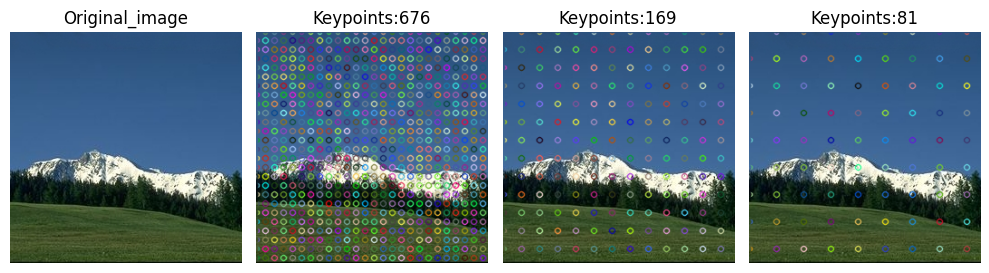

In [16]:
# Show dense keypoints with different steps size
list_steps = [10,20,30]
dense_kps = []
for steps in list_steps:
    dense_kps.append(create_dense_kp(gray.shape, step_size=steps))
show_keypoints_dense(sample, kps=dense_kps)


#### The dense DAISY descriptor

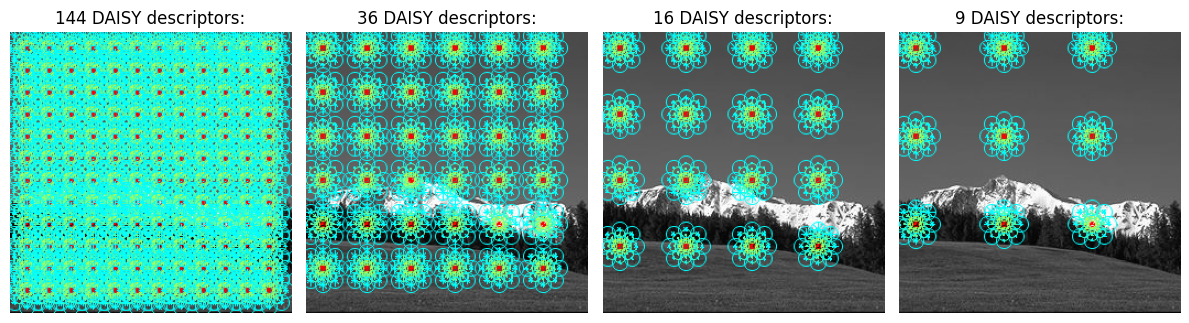

In [17]:
#demonstration of the Daisy Descriptor
img = cv2.imread(sample)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(Image.open(sample))

fig, axes = plt.subplots(1,4, figsize = (12,8))
steps = [20, 40, 60, 80]

for ax, step in zip(axes.flatten(),steps):
    des, des_img = daisy(gray, step = step, visualize = True)
    des = des.reshape(-1, des.shape[2])
    ax.imshow(des_img)
    ax.set_title('%i DAISY descriptors:' % des.shape[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

#### **Let's finetune the parameters of the dense descriptor**

Here, we are tuning the hyperparameter by 10 (stratified) fold cross-validation.

#### Dense SIFT: Finding the best step size

In [18]:
d_sift_gs = pd.read_csv('optimize_sift_dense.csv', index_col=False)
plot_metrics(d_sift_gs, 'Step size')

#### Dense SURF: Finding the best step size

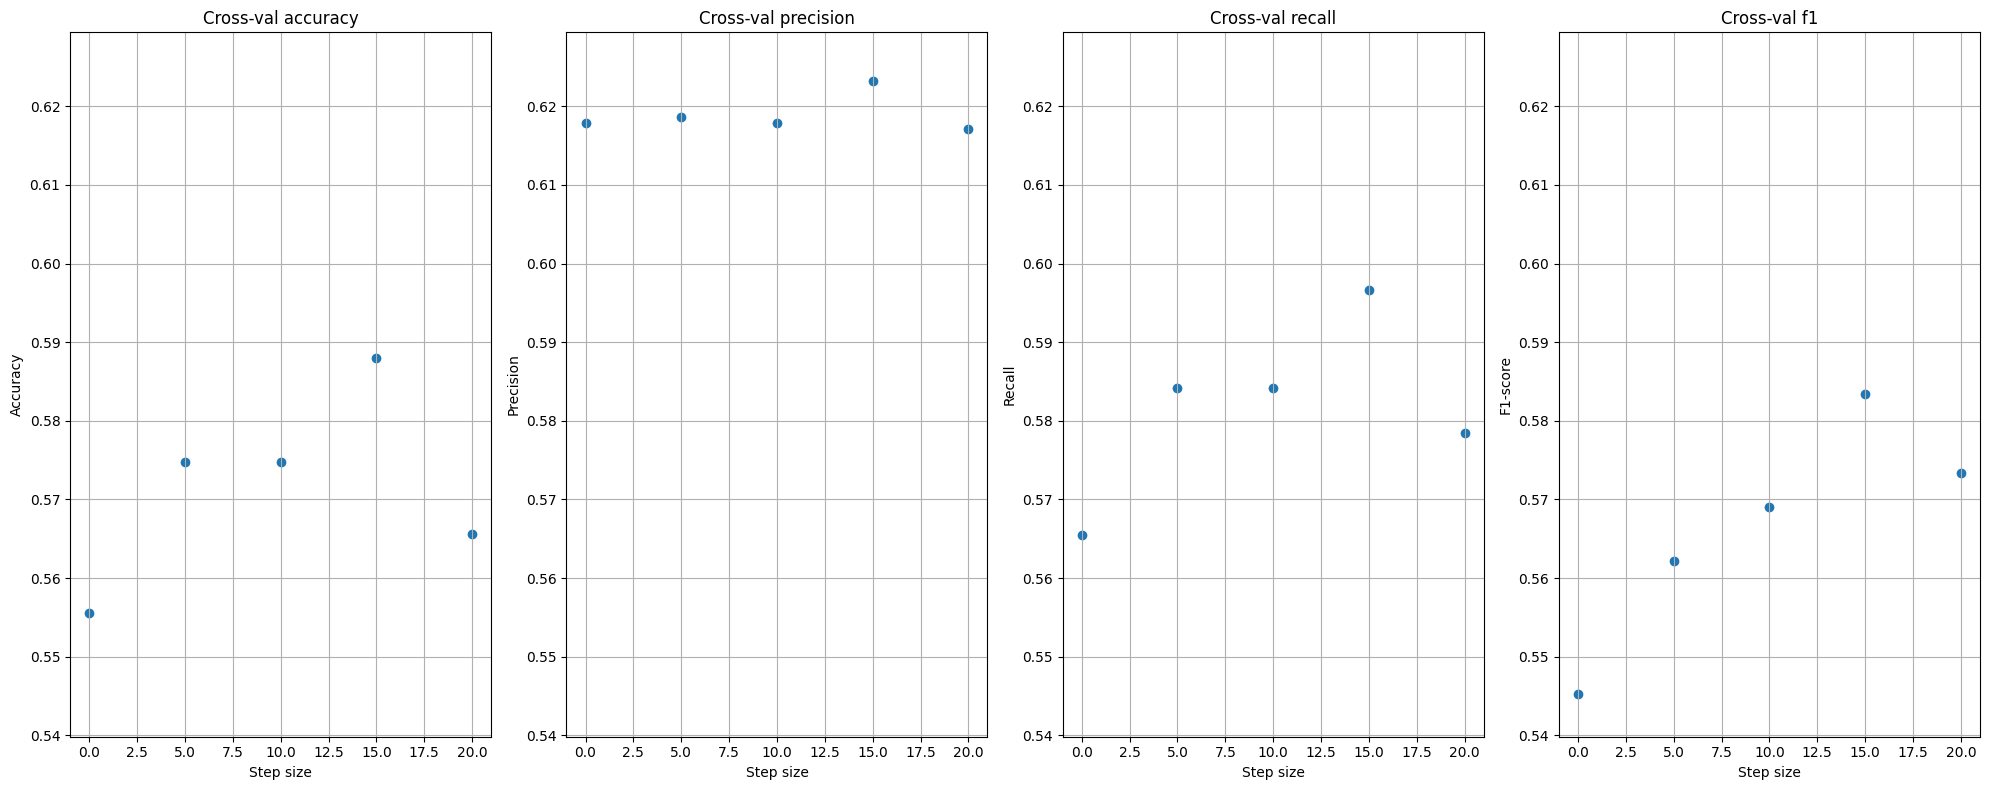

In [19]:
d_surf_gs = pd.read_csv('optimize_surf_dense.csv', index_col=False)
plot_metrics(d_surf_gs, 'Step size')

#### Daisy: Finding the best step size

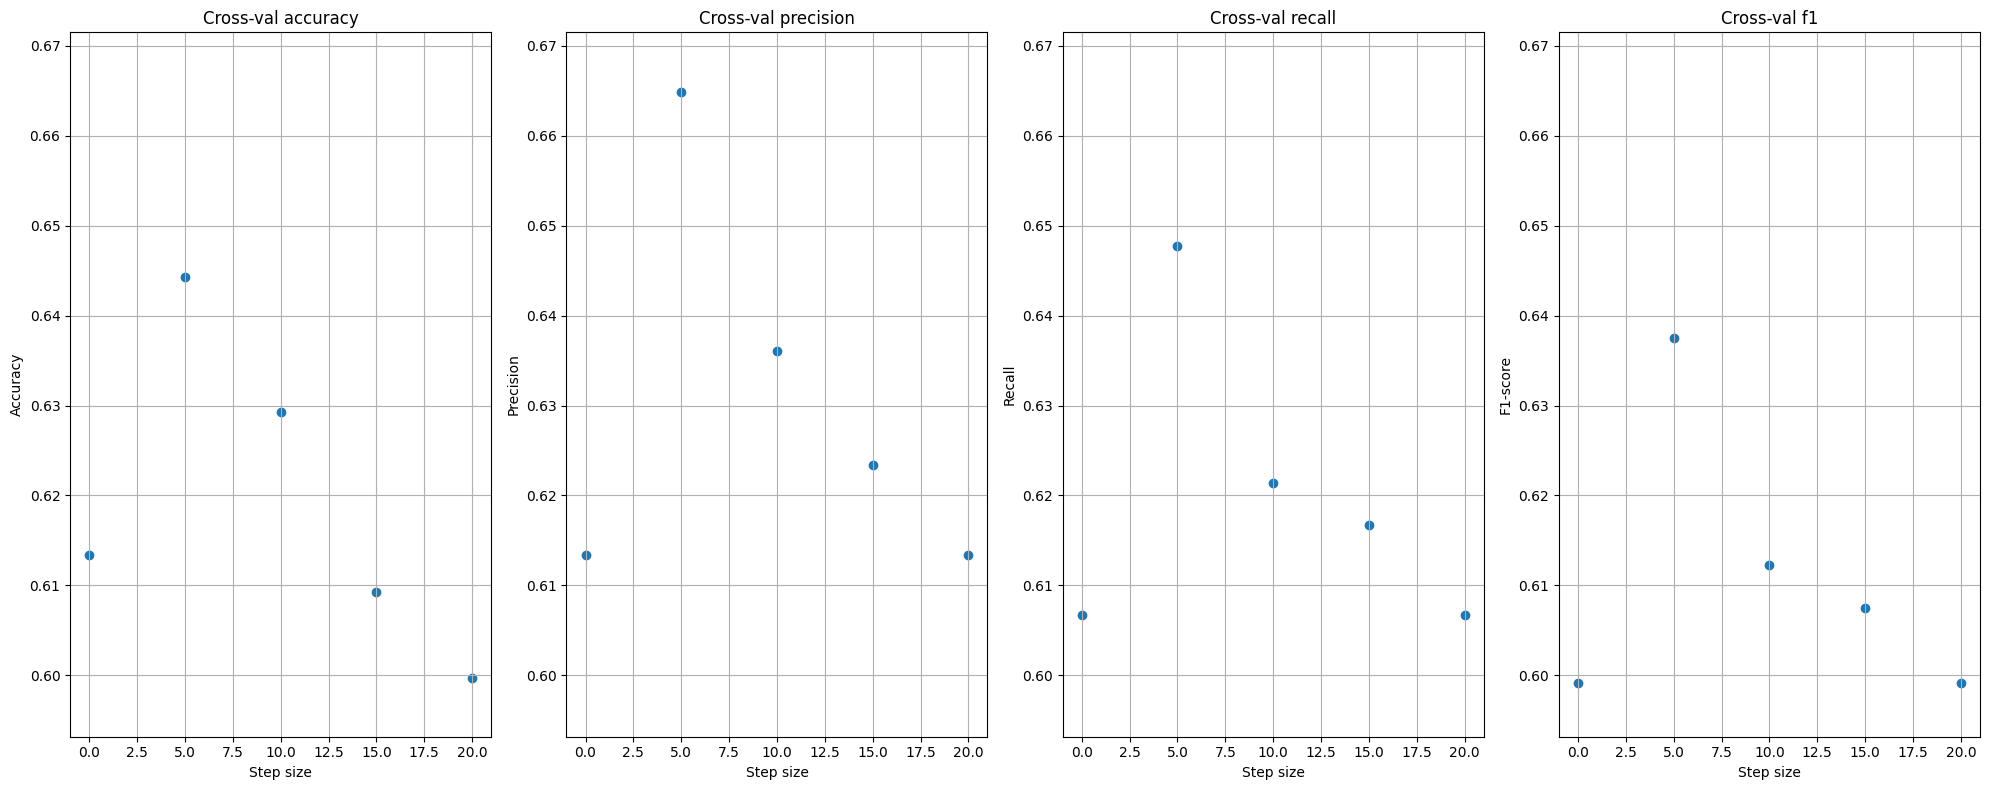

In [20]:
daisy_gs = pd.read_csv('optimize_daisy.csv', index_col=False)
plot_metrics(daisy_gs, 'Step size')

#### **Conclusions**

*   The dense descriptors outperform (vanilla) SIFT and SURF based on the performance of the keypoint detector. As by using the dense keypoints, we get a representative descriptor of the images even if the content of the image has low textures or reptitve patterns.

*   In all the cases, with a smaller step size we're using more keypoints and therefore the resulting feature descriptor is more representative. (**For SIFT its 10, SURF 15, and the DAISY = 5**)

*   The performance of BRISK and AKAZE don't depend on the step size, as they're only vanilla descriptor.

* The computational cost of using grid search to evaluate these descriptors becomes prohibitively expensive when dealing with a large number of parameters to consider.

Among all descriptors, **Dense SIFT outperform the others** so we are going to use it for rest of the experiment.

### **4. Spatial Pyramids** <a id="sp"></a>

In order to efficiently aggregate local features into a single global vector, however, it completely ignores the spatial layout information. To effectively address this issue, we can utilize a strategy called spatial pyramids, which involves partitioning the image into increasingly fine sub-regions and computing the keypoints and descriptors at different pyramidal levels. This technique allows us to aggregate the local features into a single global vector while preserving the spatial layout information.



In [21]:
# for sift and surf
def spatial_pyramid(img, descriptor, level=1, dense=False, step_size=15):
    if dense:
        dense_kp = create_dense_kp(img.shape, step_size=step_size)
        _,des = descriptor.compute(img, dense_kp)

    else:
        _,des=descriptor.detectAndCompute(img,None)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        if dense:
            dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]

                if dense:
                    _,des = descriptor.compute(cell, dense_kp_cell)
                else:
                    _,des = descriptor.detectAndCompute(cell, None)

                pyramid_descriptors.append(des)
    return pyramid_descriptors

In [22]:
# for daisy
def spatial_pyramid_daisy(img, step=30, level=1):
    des = daisy(img, step=step)
    des = des.reshape(-1,des.shape[2])

    # list that contains the descriptors of img at different levels
    pyramid_descriptors = [des]

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)

        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]
                des = daisy(cell, step=step)
                des = des.reshape(-1,des.shape[2])
                pyramid_descriptors.append(des)
                
    return pyramid_descriptors

#### **Tuning spatial pyramid level**

We compute the accuracy and average precision, recall and f1-score with 10 (stratified) fold cross-validation to tune the parameter "pyramid level".

We are also using the codebook size = 256, KNN-Classifier with K=5 using cosine distance.

In [23]:
#cross-val accuracy
spl_acc = pd.read_csv('./cross_val_acc_spl.csv')
spl_acc.head()

Spatial pyramid level   SIFT   SURF  BRISK  AKAZE  Dense SIFT  Dense SURF  \
0                      0  0.533  0.618  0.529  0.472       0.696       0.565   
1                      1  0.595  0.633  0.563  0.481       0.733       0.572   
2                      2  0.572  0.647  0.559  0.477       0.738       0.568   

   DAISY  
0  0.648  
1  0.655  
2  0.639

In [24]:
#cross-val precision
spl_pre = pd.read_csv('./cross_val_pre_spl.csv')
spl_pre.head()

Spatial pyramid level   SIFT   SURF  BRISK  AKAZE  Dense SIFT  Dense SURF  \
0                      0  0.595  0.632  0.597  0.485       0.741       0.594   
1                      1  0.602  0.651  0.602  0.492       0.758       0.587   
2                      2  0.597  0.631  0.591  0.486       0.758       0.587   

   DAISY  
0  0.644  
1  0.663  
2  0.661

In [25]:
#cross-val recall
spl_rec = pd.read_csv('./cross_val_rec_spl.csv')
spl_rec.head()

Spatial pyramid level   SIFT   SURF  BRISK  AKAZE  Dense SIFT  Dense SURF  \
0                      0  0.555  0.602  0.577  0.455       0.721       0.574   
1                      1  0.592  0.632  0.582  0.482       0.738       0.581   
2                      2  0.587  0.621  0.581  0.476       0.738       0.581   

   DAISY  
0  0.664  
1  0.673  
2  0.661

In [26]:
#cross-val f1 score
spl_f1 = pd.read_csv('./cross_val_f1_spl.csv')
spl_f1.head()

Spatial pyramid level   SIFT   SURF  BRISK  AKAZE  Dense SIFT  Dense SURF  \
0                      0  0.551  0.603  0.556  0.441       0.715       0.561   
1                      1  0.592  0.635  0.561  0.459       0.734       0.564   
2                      2  0.576  0.627  0.542  0.461       0.735       0.558   

   DAISY  
0  0.651  
1  0.659  
2  0.648

#### **Conclusions of this section**

*   Comparing all the descriptors with different pyramid levels, we observe that level 1 is outperforms the level 0 as expected which proves the importance of spatial information.

*   level 2 also slightly outperform the level 1 (**specially for Dense SIFT**) but it is computionally expensive (21 vs 5 histograms). Also with level 2 curse of dimesionality also comes into picture as our feature space becomes sparse.

Because of the above explanations, from now onwards we'll use Dense SIFT with step size = 10, and pyramid level = 1

In [27]:
#Here, we are going to compute the training descriptors for our model with
#Nfeatures = 1500, step size = 10, spatial pyramid level = 1
Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=10)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

### **5. Clustering** <a id="kmeans"></a>

In [28]:
#Let's try the minibatch Kmeans
k = 64
codebook_by_KMeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_by_KMeans.fit(D)

MiniBatchKMeans(batch_size=1280, compute_labels=False, n_clusters=64,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

We have also tried to cluster the feature space using KMedoids. However, it was so computationally expensive that the Kernel crashed while executing the following code. So we discarded it.

````python
k = 128
codebook_by_KMedoids = KMedoids(n_clusters = k, random_state = 0)
codebook_by_KMedoids.fit(D)
````

As KMeans is fast and efficient we have decided to continue with the optimum codebook size.



#### **Tuning the codebook size (k)**
Here we have the same gridsearch experiment as mentioned in Section 4.

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/1499429969.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  codebook_size_gs = pd.read_csv('./optimize_sift_dense_pyramid.csv', index_col = False)


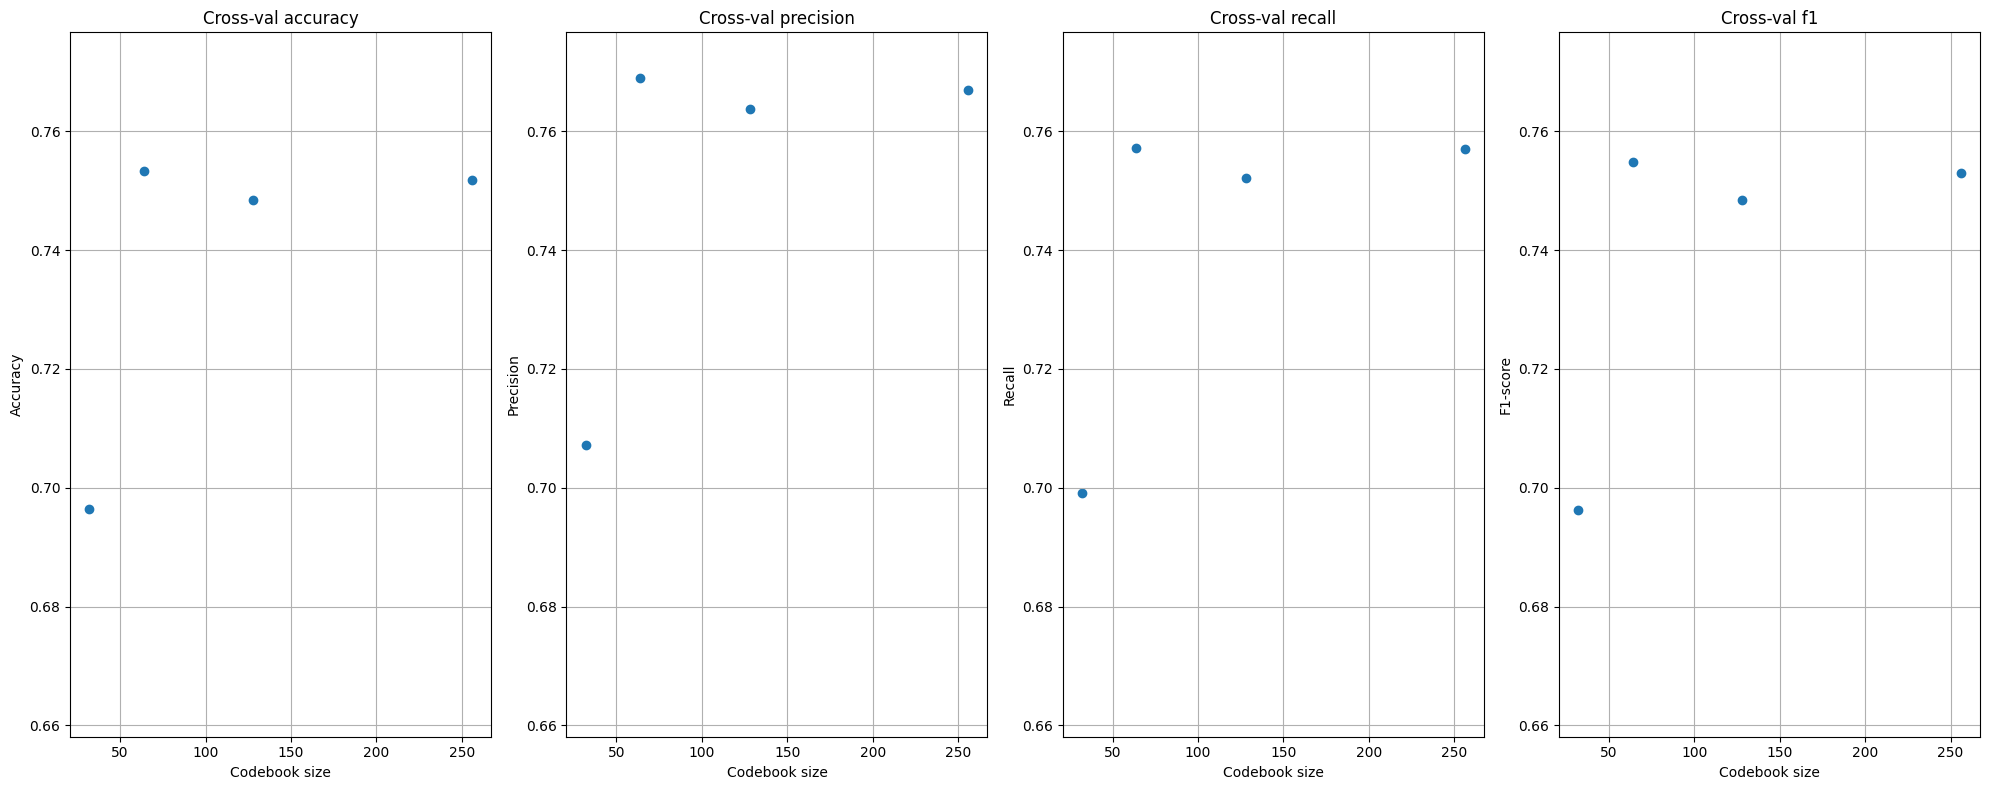

In [29]:
codebook_size_gs = pd.read_csv('./optimize_sift_dense_pyramid.csv', index_col = False)
plot_metrics(codebook_size_gs, 'Codebook size')

The **codebook size 64** is best for the rest of the experiment. Now let us compute the histograms of the sub-regions of the image explained in Section 4. For each train image, we project each keypoint descriptor to its closest visual word that represent each of the images with the frequency of each visual word through histograms. 

In [30]:
# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

In [31]:
visual_words_pyramid=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook_by_KMeans, k)

#### **Take away home messages**

*   A small codebook size contain too general visual words which is not a proper representation of the image.

*   With a large codebook size, the visual words are too specific, so the features are not properly grouped.

* That's why for the rest of the experiment we'll use **Dense SIFT** with **Nfeatures = 1500, step size = 10, Spatial pyramid level = 1 and Codebook size = 64**.

### **6. Classifiers** <a id="cls"></a>
Based on the above training features we are going to defined the following classifers for the given dataset.

#### **6.1 KNN-Classifiers** <a id="knn"></a>
In this section, we are going to build a k-nn classifier and train it with the train descriptors. In order to decide which is the best distance metric and the optimum number of neighbours(k), we are judging based on the mean accuracy and standard deviation with 10-fold cross validation. 

#### **Finding the best distance metric**

In [32]:
parameters = {'metric':('manhattan', 'euclidean','chebyshev', 'minkowski',
                        'braycurtis', 'jaccard', 'canberra', 'cosine') }
knn_g = KNeighborsClassifier()
grid = GridSearchCV(knn_g, parameters, cv = 10)
grid.fit(visual_words_pyramid, train_labels)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolea

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ('manhattan', 'euclidean', 'chebyshev',
                                    'minkowski', 'braycurtis', 'jaccard',
                                    'canberra', 'cosine')})

In [33]:
knn_metrics_pd = pd.DataFrame.from_dict(grid.cv_results_)
knn_metrics_pd[['param_metric','mean_test_score','std_test_score','rank_test_score']]

param_metric  mean_test_score  std_test_score  rank_test_score
0    manhattan         0.773525        0.042429                1
1    euclidean         0.740034        0.038371                4
2    chebyshev         0.653920        0.040137                8
3    minkowski         0.740034        0.038371                4
4   braycurtis         0.773525        0.042429                1
5      jaccard         0.711834        0.044096                6
6     canberra         0.670368        0.050801                7
7       cosine         0.750127        0.049069                3

<AxesSubplot:xlabel='param_metric', ylabel='mean_test_score'>

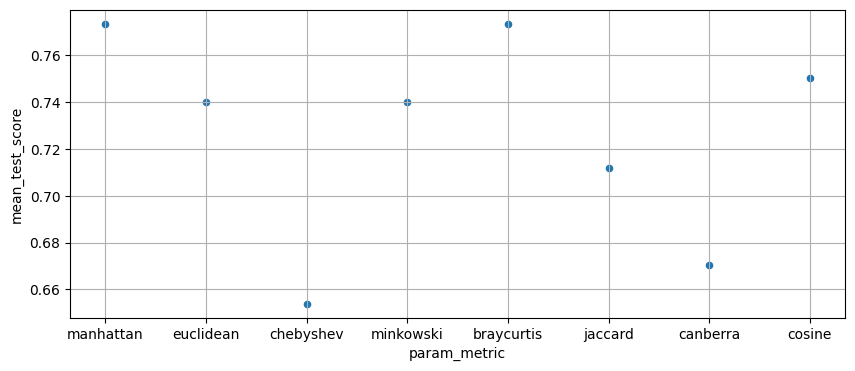

In [34]:
knn_metrics_pd.plot.scatter(x='param_metric',y='mean_test_score',figsize=(10,4), grid=True)  

Here, **manhattan** and **braycurtis** achieve same peformance. So from now onwards we are going to use **braycurtis** distance. 
Now, using this distance let's get the optimum number of K.

#### **Finding the optimum K**

In [35]:
parameters = {'n_neighbors':[2,4,8,16,32,64] }
knn_g2 = KNeighborsClassifier(metric='braycurtis')
grid2 = GridSearchCV(knn_g2, parameters, cv = 10)
grid2.fit(visual_words_pyramid, train_labels)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(metric='braycurtis'),
             param_grid={'n_neighbors': [2, 4, 8, 16, 32, 64]})

In [36]:
knn_neighbours_pd = pd.DataFrame.from_dict(grid2.cv_results_)
knn_neighbours_pd[['param_n_neighbors','mean_test_score','std_test_score','rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                 2         0.709721        0.041812                6
1                 4         0.765017        0.044622                5
2                 8         0.782554        0.036856                1
3                16         0.779357        0.043299                2
4                32         0.775113        0.041582                3
5                64         0.767154        0.041478                4

<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

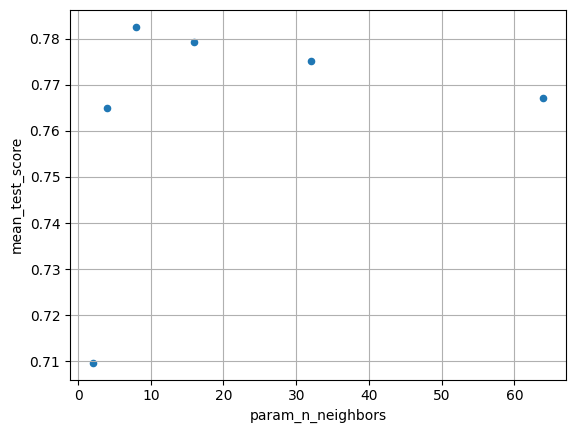

In [37]:
knn_neighbours_pd.plot.scatter(x='param_n_neighbors',y='mean_test_score', grid=True)  

#### **Conclusions**

*   Regrading the distance metric the **manhattan** and **braycurtis** achieve same results but we choose braycurtis as the braycurtis defined as:

    ${d} = \frac{\sum |u_i - v_i|}{\sum|u_i + v_i|}$

    which basically normalizes the manhattan distances and provides more stability to the model.

*   Regarding the number of neighbours, we should choose it to be large enough so that the noise in the data is minimized, but small enough so that samples from other classes are not included. We choose **8** to yield better results. 

#### **6.2 Logistic Regression** <a id="logreg"></a>

We have also built a logistic regression classifier and trained it with the codebook of the descriptors we have generated. Here we are willing which one is the best solver for logistic regression.

In [38]:
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga',)}
logreg_g = LogisticRegression(max_iter = 20)
grid3 = GridSearchCV(logreg_g, parameters, cv=10)
grid3.fit(visual_words_pyramid, train_labels)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=20),
             param_grid={'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')})

In [39]:
log_solver_pd = pd.DataFrame.from_dict(grid3.cv_results_)
log_solver_pd[['param_solver','mean_test_score','std_test_score','rank_test_score']]

param_solver  mean_test_score  std_test_score  rank_test_score
0    newton-cg         0.790001        0.041921                4
1        lbfgs         0.804869        0.039964                3
2    liblinear         0.763410        0.037478                5
3          sag         0.820826        0.040842                2
4         saga         0.822430        0.037721                1

<AxesSubplot:xlabel='param_solver', ylabel='mean_test_score'>

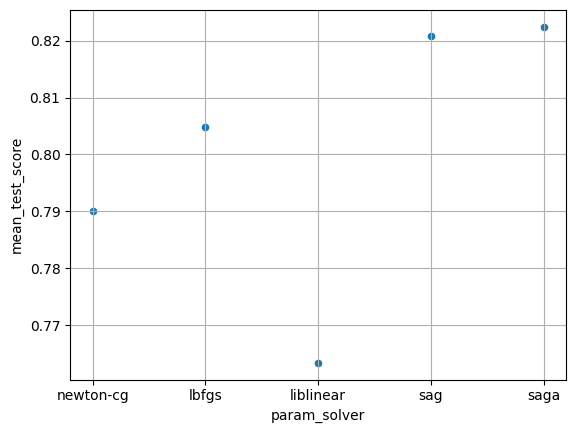

In [40]:
log_solver_pd.plot.scatter(x='param_solver',y='mean_test_score', grid=True)

We have also perform for the gridsearch for max_iter, C (inverse of the regularization parameter) and random_state, and we obtained the best result with **max_iter = 20, C = 1, and random_state = 0 along with the saga solver.** 

The logistic regression outperforms the KNN for this problem, so from now onwards we will use logistic regression with saga solver for the rest of the experiments.

### **7. Dimensionality Reduction** <a id="dr"></a>
Here we are going to discuss various dimension reduction techniques with their optimum parameter to find their effect on this particular classification problem.

#### **7.1 Principal Component Analysis** <a id="pca"></a>
For PCA, we can set the parameter **n_components** to select the number of dimensions or the percentage of information of the data to be kept after the dimensionality reduction.

The parameter **n_components** represents a percentage if it's between 0 and 1 or a number of dimensions if it's > 1. For each of these cases, we used gridsearch to tune it.

In [41]:
pca = PCA(n_components=0.8, svd_solver='full') # if it's between 0 and 1 -> percentage
VWpca = pca.fit_transform(visual_words_pyramid)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWpca, train_labels)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

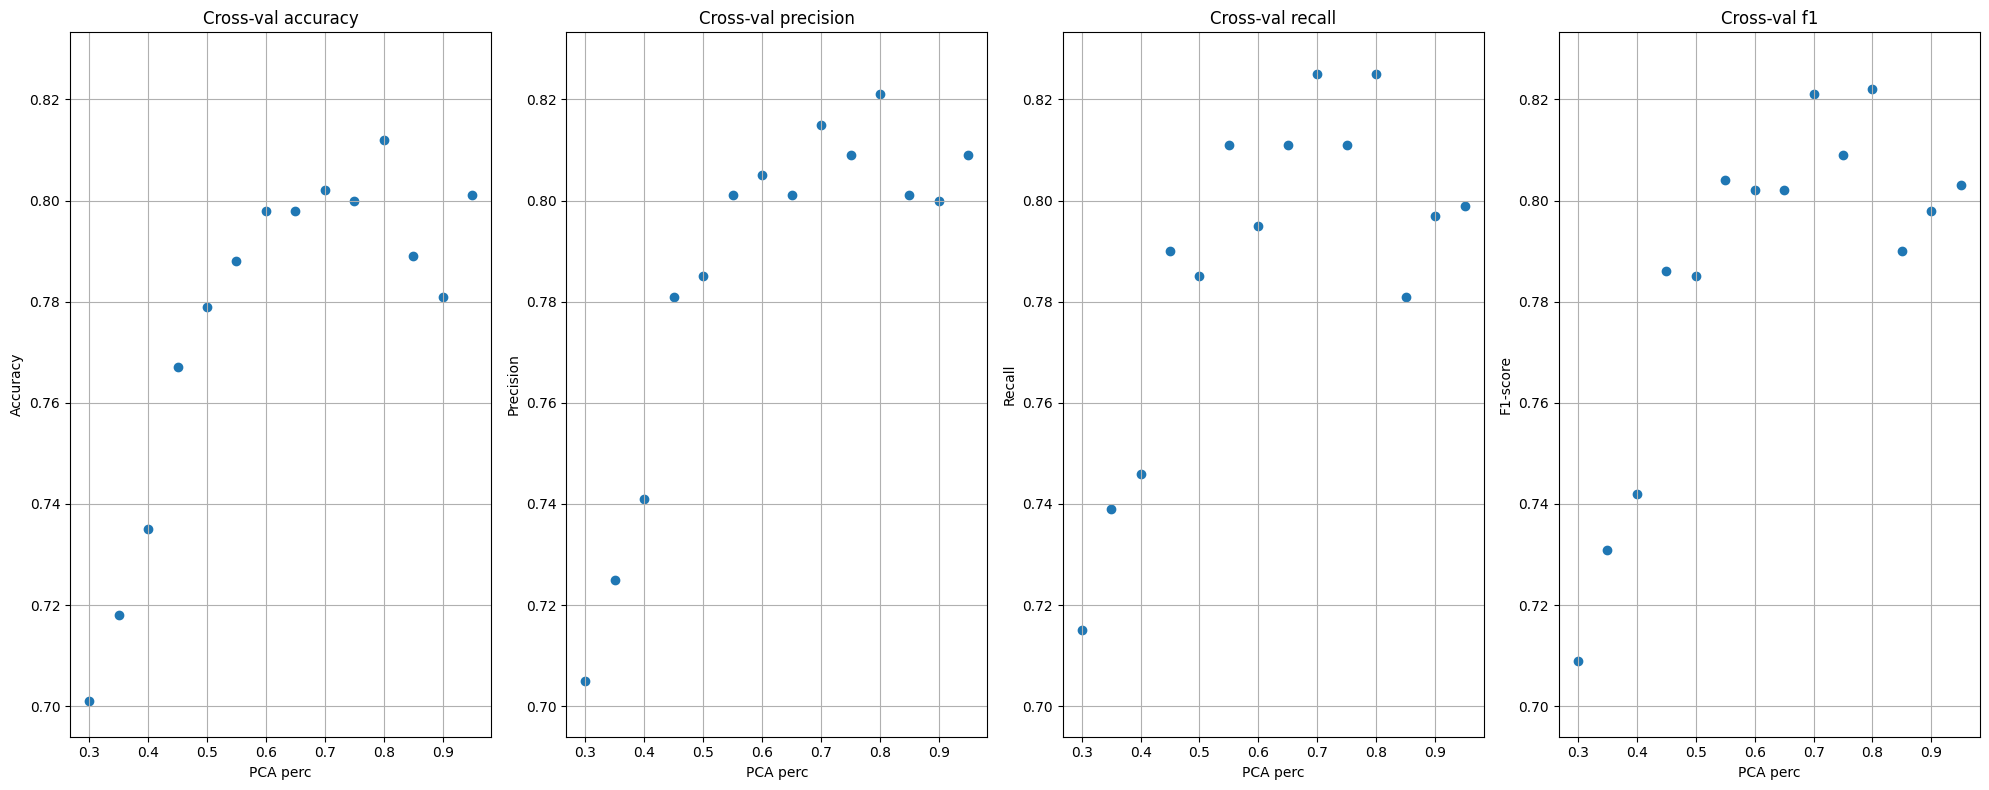

In [42]:
pca_perc_gs = pd.read_csv('./opt_ds_sfit_pca_perc.csv', index_col = False)
plot_metrics(pca_perc_gs, 'PCA perc')

In [43]:
pca = PCA(n_components=64, svd_solver='full') # if it's > 1 -> number of dimensions
VWpca = pca.fit_transform(visual_words_pyramid)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWpca, train_labels)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

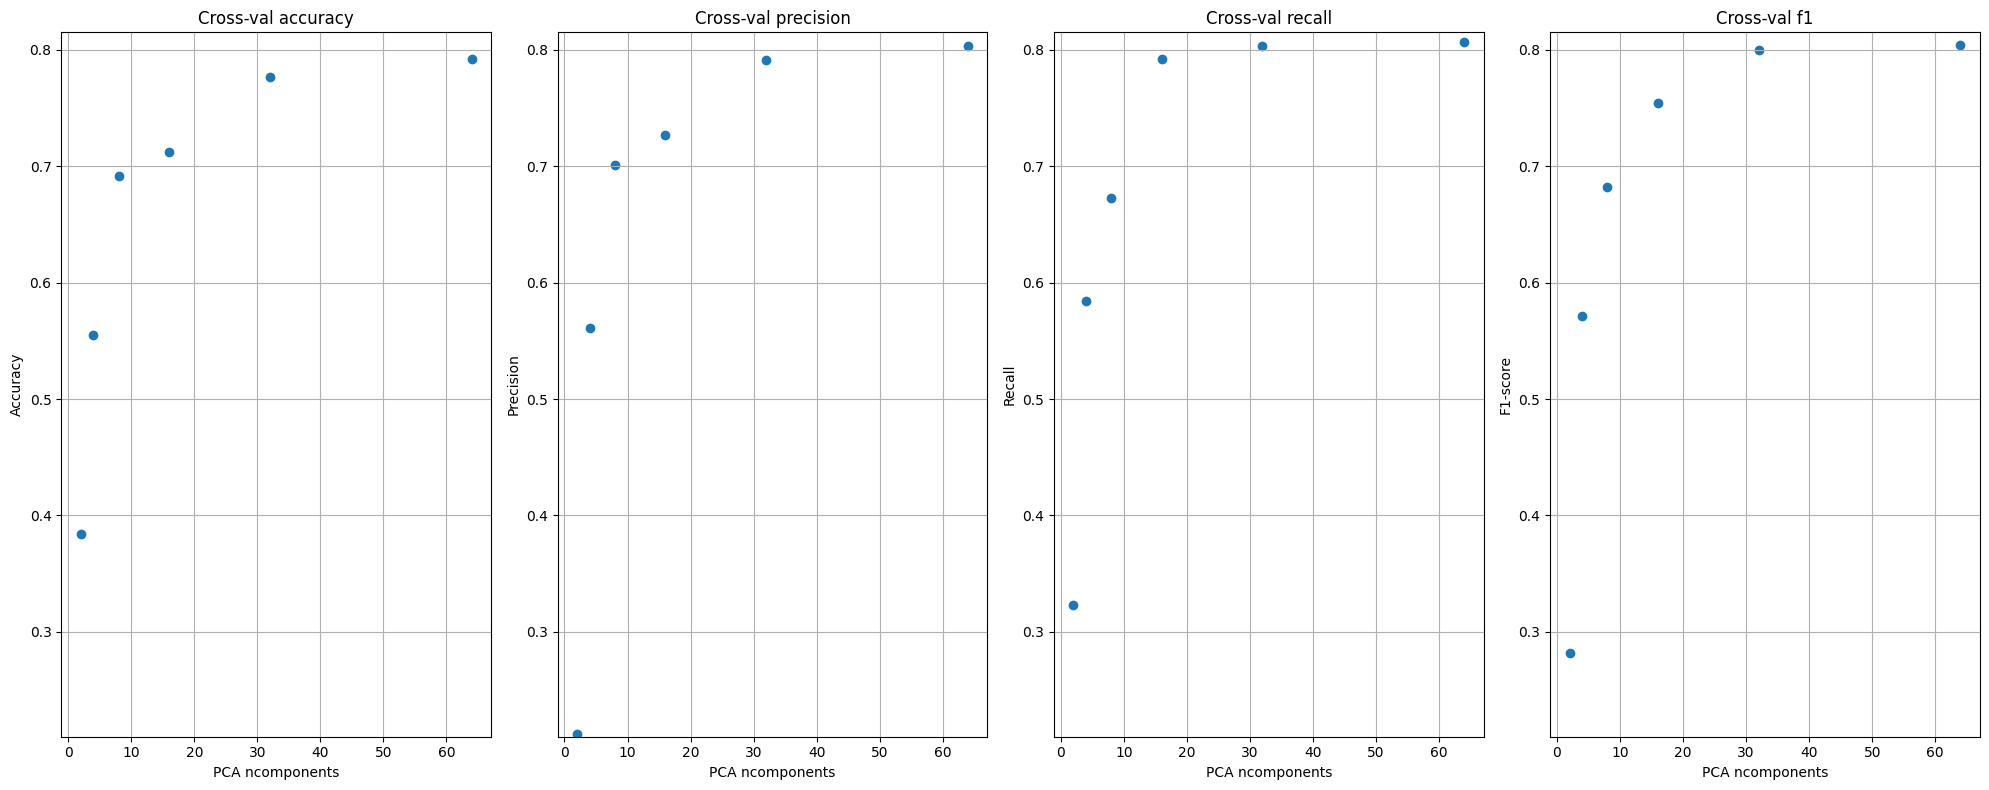

In [44]:
pca_dim_gs = pd.read_csv('./opt_ds_sift_pca_comp.csv', index_col=False)
plot_metrics(pca_dim_gs, 'PCA ncomponents')

#### **7.2 Linear Discriminant Analysis** <a id="lda"></a>
For LDA, we need the no. of components to be **<= min(num_classes-1, nfeatures)**. LDA helps to obtain a decision boundary around each cluster of a class. It then projects the data points to new dimensions in a way that the clusters are separable from each other. So, we have **n - (classes -1)** distances to optimize.

In [45]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver = 'saga')
classifier.fit(VWlda, train_labels) 

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(solver='saga')

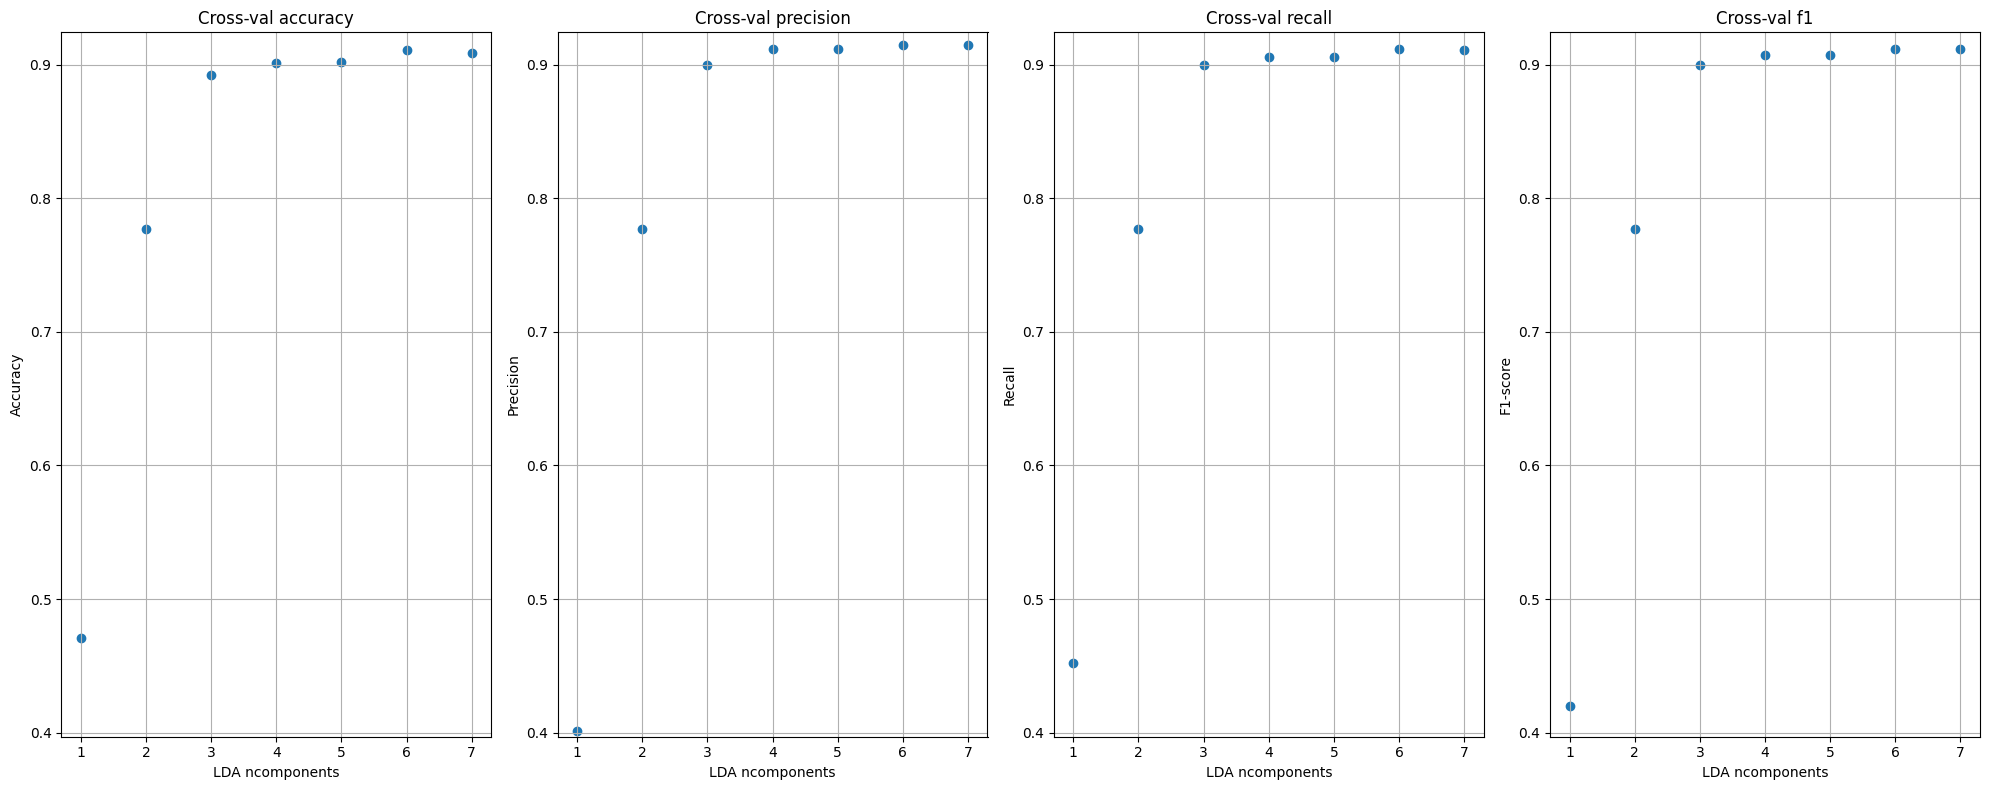

In [46]:
lda_gridsearch = pd.read_csv('./opt_ds_sift_lda_comp.csv', index_col=False)
plot_metrics(lda_gridsearch, 'LDA ncomponents')

#### **Take away home messages**

*   Applying PCA doesn't increase the performance as we alrady find the optimal number of features to use through gridsearch. However, it speeds up the computation without affecting the performance.

*   For LDA, with a **ncomponents > 2** the results are highly improved as it maximize the separability between the classes. The best results are obtained **ncomponents = 6, and 7**. We will use **ncomponents = 7** for the rest of our experiments.

### **8. Cross Validation** <a id="cv"></a>

>   **Note that:** we have already used the cross-validation on the gridsearch to obtain the best parameters. However, here we are showing the best performance with the combination of all the experiments that we performed above.

In [47]:
#DenseSIFT, Nfeatures = 1500, Step size = 10, Spatial Pyramid level = 1, Codebook Size = 64
#Logistic Regression with solver = saga, max_iter = 20, C = 1
#LDA with 7 components
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver='saga', max_iter = 20)
cv_scores = cross_validate(classifier, VWlda, 
                          train_labels,scoring = ['accuracy', 'precision_macro', 'recall_macro','f1_macro'], 
                          cv=10)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adv

In [48]:
cross_validation_pd = pd.DataFrame.from_dict(cv_scores)
cross_validation_pd.round(4)

fit_time  score_time  test_accuracy  test_precision_macro  \
0    0.0089      0.0025         0.9153                0.9140   
1    0.0170      0.0039         0.9149                0.9200   
2    0.0135      0.0019         0.8936                0.9019   
3    0.0144      0.0018         0.9202                0.9285   
4    0.0082      0.0018         0.9521                0.9590   
5    0.0245      0.0021         0.9149                0.9173   
6    0.0106      0.0018         0.9096                0.9139   
7    0.0147      0.0018         0.9362                0.9391   
8    0.0116      0.0021         0.9415                0.9440   
9    0.0100      0.0019         0.8989                0.8986   

   test_recall_macro  test_f1_macro  
0             0.9106         0.9113  
1             0.9132         0.9151  
2             0.9016         0.8999  
3             0.9245         0.9231  
4             0.9552         0.9549  
5             0.9146         0.9156  
6             0.9187         0.9157  
7             0.9377         0.9369  
8             0.9394         0.9404  
9             0.9006         0.8974

In [49]:
print("%0.2f accuracy with a std dev of %0.2f" % (cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()))
print("%0.2f precision with a std dev of %0.2f" % (cv_scores['test_precision_macro'].mean(), cv_scores['test_precision_macro'].std()))
print("%0.2f recall with a std dev of %0.2f" % (cv_scores['test_recall_macro'].mean(), cv_scores['test_recall_macro'].std()))
print("%0.2f F1-score with a std dev of %0.2f" % (cv_scores['test_f1_macro'].mean(), cv_scores['test_f1_macro'].std()))

0.92 accuracy with a std dev of 0.02
0.92 precision with a std dev of 0.02
0.92 recall with a std dev of 0.02
0.92 F1-score with a std dev of 0.02


#### **Conclusions**

*   Within the different 10 folds, the system presents a low std dev of 0.02, which allows us to validate the consistency of our system.

*   We obtain an accuracy of 0.92 and an average precision, recall and F1-score of 0.92, which are already expected from LDA analysis results.

*   In addition, by using LDA, the execution is really fast (low score_time), as this technique allows reducing the feature dimensionality and thus the computational cost.


### **9. Test Validation** <a id='tv'></a>

As we trained our classifier with optimum no. of features and cross validate it, now it's time to test the defined system.

In [50]:
visual_words_test=np.zeros((len(test_images_filenames),visual_words_pyramid.shape[1]),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=10)
    visual_words_test[i,:] = spatial_pyramid_histograms(pyramid_des, codebook_by_KMeans, k=64)

In [51]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid,train_labels)

classifier = LogisticRegression(solver='saga')
classifier.fit(VWlda, train_labels)

vwtestlda = lda.transform(visual_words_test) 
test_lda_prediction = classifier.predict(vwtestlda)
test_lda_precision, test_lda_recall, test_lda_fscore, _ = precision_recall_fscore_support(test_labels, test_lda_prediction, average='macro')
test_lda_accuracy = classifier.score(vwtestlda, test_labels)

print("%0.2f accuracy" % (test_lda_accuracy))
print("%0.2f precision" % (test_lda_precision))
print("%0.2f recall" % (test_lda_recall))
print("%0.2f F1-score" % (test_lda_fscore))

0.82 accuracy
0.83 precision
0.83 recall
0.83 F1-score


/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### **Conclusions**

As observed, the performance of the classifier in the test dataset is acceptable, but much worse than with the training dataset. One of the reasons can be an overfitting of the classifier, which means that it's not generalizing well to unseen datasets. With a larger training dataset or other classifier (may be support vector machine), we expect to improve the results.

### **10. Visualization of Results** <a id = 'roc'></a>

We will plot the **ROC Curve** to visually analyze the behaviour of our classifier when treating it as a one vs all binary classifier.

In [52]:
# first we need to binarize the labels
y_train = LabelBinarizer().fit_transform(train_labels)
y_test = LabelBinarizer().fit_transform(test_labels)
n_classes = y_train.shape[1]
print(y_train)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [53]:
# classifier
clf = OneVsRestClassifier(LogisticRegression(solver='saga'))
clf.fit(VWlda, y_train)
y_score = clf.predict_proba(vwtestlda)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
# Then interpolate all ROC curves 
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/1169533911.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


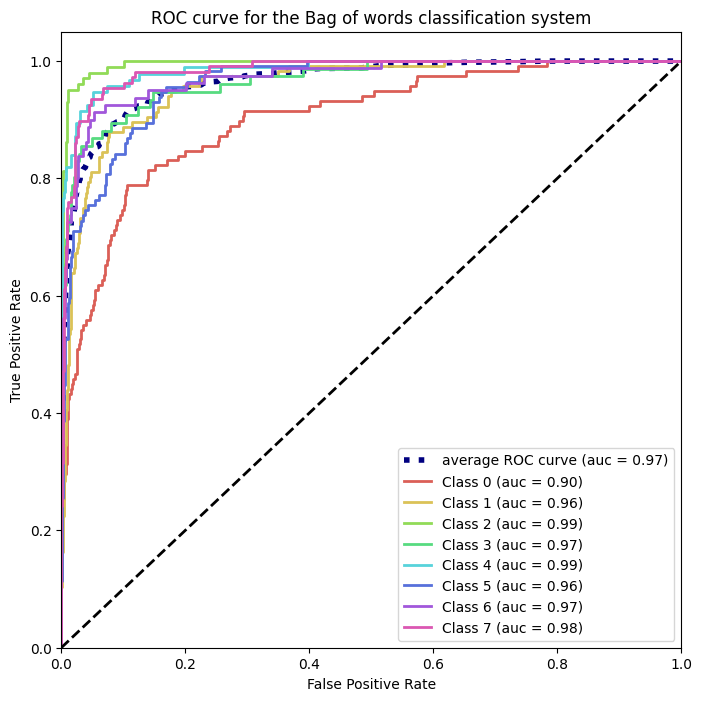

In [55]:
# Plot all ROC curves
plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr["macro"], tpr["macro"],
         label='average ROC curve (auc = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

palette = sns.color_palette("hls", 8)
colors = cycle(palette)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (auc = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the Bag of words classification system')
plt.legend(loc="lower right")
plt.show()

#### **Conclusions**

*   We can observe that the class that is best classified is class 2 and class 4, that correspond to forests and inside_city respectively. Having a look at the images visualized on Dataset, we can see how the forest dataset is mainly formed by trees, so that have a similar pattern of textures and colors, doesn't matter how the forest is.

*   On the other hand, the class that is worst classified is class 0, which is Opencountry. The opencountry dataset shows different kinds of landscapes, from desert to mountains, in some cases with a big part of the image being the blue sky and others showing just a bit of clouds.

#### **Visualizing Matches and Misclassifications**

Finally, we can see the exact predictions that went right and wrong using the following functions.

In [75]:
def visualize_wrong_predictions(image_filenames, labels, predictions, samples_per_class=3):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of wrongly classified samples: {sum(predictions!=labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(20,8))
    
    def get_index_fp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] != labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_fp = get_index_fp(idxs_all)
        idxs = np.random.choice(idxs_fp, samples_per_class, replace=True)
        class_accuracy = 100*(1 - (len(idxs_fp)/len(idxs_all)))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'{cls} \n ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()


def visualize_correct_predictions(image_filenames, labels, predictions, samples_per_class=3):
    print(f'Number of samples: {len(predictions)}')
    print(f'Number of correctly classified samples: {sum(predictions==labels)}')
    
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    #set size for plot
    plt.figure(figsize=(20,8))
    
    def get_index_tp(idxs):
        items = []
        for idx in idxs:
            if predictions[idx] == labels[idx]:
                items.append(idx)
        return items
    
    for y, cls in enumerate(classes):
        idxs_all = np.flatnonzero(np.array(labels) == cls)
        idxs_tp = get_index_tp(idxs_all)
        idxs = np.random.choice(idxs_tp, samples_per_class, replace=False)
        class_accuracy = 100*(len(idxs_tp)/len(idxs_all))
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(Image.open(image_filenames[idx]))
            plt.axis('off')
            if i == 0:
                plt.title(f'ClassAccuracy: {class_accuracy:.2f}  \n GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
            else:
                plt.title(f'GT: {test_labels[idx]},\n Pred: {predictions[idx]}')
    plt.show()

Number of samples: 807
Number of wrongly classified samples: 276


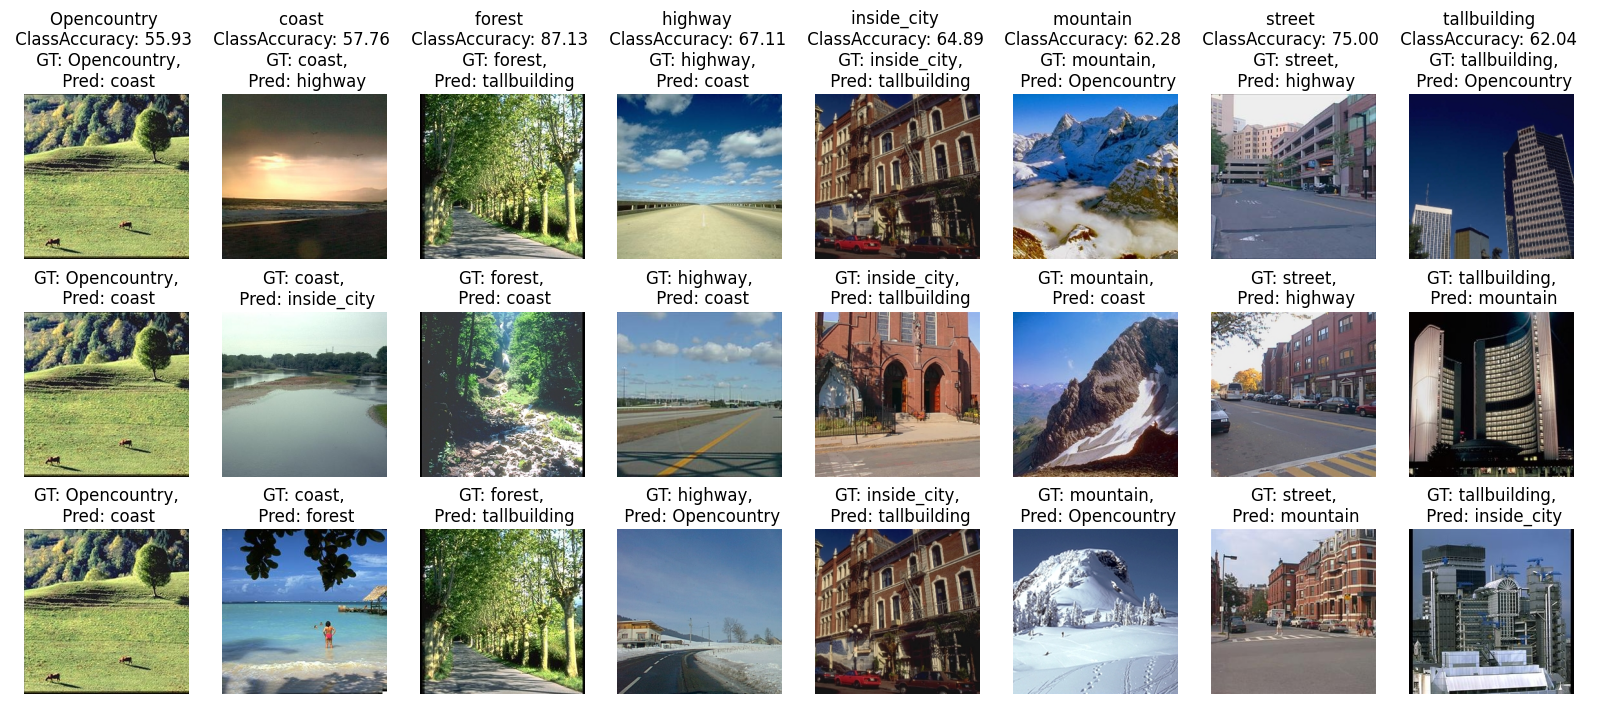

In [76]:
visualize_wrong_predictions(test_images_filenames, test_labels, test_lda_prediction)

In [58]:
visualize_correct_predictions(test_images_filenames, test_labels, test_lda_prediction)

Number of samples: 807
Number of correctly classified samples: 662


### **Additional: Experiment with random search**

To understand the hyperparameter values predicted by grid search is accurate or not we have performed same experiments with random grid search.

### **Random grid search**

>   **Note that:** Using random grid search, we searched for the optimum parameters for the KNN (distance and K) and the PCA (percentage of explanation). This means that we still need to find the best parameters and compare them with the Logistic Regression and LDA respectively.  

#### **SIFT: Finding the best number of features with random grid search**

In [59]:
#sift
sift_opt_gs = pd.read_csv('./optimize_sift_random.csv', index_col=False)
max_index = sift_opt_gs['Cross-val f1'].idxmax()
# get the rows with the max values using the index
max_rows = sift_opt_gs.loc[max_index]
print(max_rows)

Descriptor                    SIFT
Spatial pyramid level            1
Codebook size                  256
k knn                           15
distance knn                cosine
Step size                       25
PCA perc                      0.75
NFeatures                      800
Cross-val accuracy        0.594895
Cross-val precision       0.602326
Cross-val recall          0.600459
Cross-val f1              0.580861
Test prec                 0.651068
Test recall               0.642626
Test f1                   0.627415
Test acc                 64.064436
PCA Test acc             74.597274
LDA Test acc              0.714006
Name: 41, dtype: object


/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/1902379538.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  sift_opt_gs = pd.read_csv('./optimize_sift_random.csv', index_col=False)


In [60]:
sample = train_images_filenames[25]
img = cv2.imread(sample)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]
# for sift and surf
def spatial_pyramid(img, descriptor, level=1, dense=False, step_size=15):
    if dense:
        dense_kp = create_dense_kp(img.shape, step_size=step_size)
        _,des = descriptor.compute(img, dense_kp)

    else:
        _,des=descriptor.detectAndCompute(img,None)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        if dense:
            dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]

                if dense:
                    _,des = descriptor.compute(cell, dense_kp_cell)
                else:
                    _,des = descriptor.detectAndCompute(cell, None)

                pyramid_descriptors.append(des)
    return pyramid_descriptors

#Here, we are going to compute the training descriptors for our model with
#Nfeatures = 1500, step size = 10, spatial pyramid level = 1

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures = 800)

Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=25)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

#Let's try the minibatch Kmeans
k = 256
codebook_by_KMeans_random = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_by_KMeans_random.fit(D)

# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

visual_words_pyramid_sift=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid_sift[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook_by_KMeans_random, k)

#### **SURF: Finding the best number of features with random grid search**

In [61]:
#surf
sift_opt_gs = pd.read_csv('./optimize_surf_random.csv', index_col=False)
max_index = sift_opt_gs['Cross-val f1'].idxmax()
# get the rows with the max values using the index
max_rows = sift_opt_gs.loc[max_index]
print(max_rows)

Descriptor                    SURF
Spatial pyramid level            1
Codebook size                   64
k knn                           25
distance knn                cosine
Step size                       15
PCA perc                       0.9
hessianThreshold                50
Cross-val accuracy        0.626244
Cross-val precision       0.638472
Cross-val recall          0.631718
Cross-val f1              0.620689
Test prec                 0.677109
Test recall                0.67422
Test f1                   0.664191
Test acc                 66.790582
PCA Test acc             76.951673
LDA Test acc               0.72092
Name: 21, dtype: object


/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/3254270136.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  sift_opt_gs = pd.read_csv('./optimize_surf_random.csv', index_col=False)


In [62]:
sample = train_images_filenames[25]
img = cv2.imread(sample)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]
# for sift and surf
def spatial_pyramid(img, descriptor, level=1, dense=False, step_size=15):
    if dense:
        dense_kp = create_dense_kp(img.shape, step_size=step_size)
        _,des = descriptor.compute(img, dense_kp)

    else:
        _,des=descriptor.detectAndCompute(img,None)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        if dense:
            dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]

                if dense:
                    _,des = descriptor.compute(cell, dense_kp_cell)
                else:
                    _,des = descriptor.detectAndCompute(cell, None)

                pyramid_descriptors.append(des)
    return pyramid_descriptors

#Here, we are going to compute the training descriptors for our model with
#Nfeatures = 1500, step size = 10, spatial pyramid level = 1

SURFdetector = cv2.xfeatures2d.SURF_create(hessianThreshold = 50)

Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SURFdetector, level=1, dense=True, step_size=15)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

#Let's try the minibatch Kmeans
k = 64
codebook_by_KMeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_by_KMeans.fit(D)

# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

visual_words_pyramid_surf=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid_surf[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook_by_KMeans, k)

#### **BRISK: Finding the best number of features with random grid search**

In [63]:
#brisk
brisk_opt_gs = pd.read_csv('./optimize_brisk_random.csv', index_col=False)
max_index = brisk_opt_gs['Cross-val f1'].idxmax() 
# get the rows with the max values using the index
max_rows = brisk_opt_gs.loc[max_index]
print(max_rows)

Descriptor                   BRISK
Spatial pyramid level            1
Codebook size                  128
k knn                           11
distance knn             euclidean
Step size                       10
PCA perc                       0.8
Threshold                        5
Cross-val accuracy        0.562491
Cross-val precision       0.599159
Cross-val recall          0.573332
Cross-val f1              0.553597
Test prec                 0.624428
Test recall               0.618095
Test f1                   0.602757
Test acc                 60.346964
PCA Test acc             65.675341
LDA Test acc              0.656058
Name: 40, dtype: object


/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/4039150643.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  brisk_opt_gs = pd.read_csv('./optimize_brisk_random.csv', index_col=False)


In [64]:
sample = train_images_filenames[25]
img = cv2.imread(sample)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]
# for sift and surf
def spatial_pyramid(img, descriptor, level=1, dense=False, step_size=15):
    if dense:
        dense_kp = create_dense_kp(img.shape, step_size=step_size)
        _,des = descriptor.compute(img, dense_kp)

    else:
        _,des=descriptor.detectAndCompute(img,None)

    # list that contains the descriptors of img at different levels,
    # being pyramid_descriptors[0] the descriptors of the whole image
    pyramid_descriptors = [des]

    # pyramid_descriptors[1:4] -> descriptors of the four cells (of size 1/4 of the image size)
    # ...

    for l in range(1,level+1):
        level_factor = 2*l
        cell_h = int(gray.shape[0]/level_factor)
        cell_w = int(gray.shape[1]/level_factor)
        
        if dense:
            dense_kp_cell = create_dense_kp([cell_h,cell_w], step_size=step_size)
            
        for f_h in range(level_factor):
            shift_h = f_h*cell_h
            for f_w in range(level_factor):
                shift_w = f_w*cell_w
                cell = img[shift_h:shift_h+cell_h, shift_w:shift_w+cell_w]

                if dense:
                    _,des = descriptor.compute(cell, dense_kp_cell)
                else:
                    _,des = descriptor.detectAndCompute(cell, None)

                pyramid_descriptors.append(des)
    return pyramid_descriptors

#Here, we are going to compute the training descriptors for our model with
#Nfeatures = 1500, step size = 10, spatial pyramid level = 1

BRISKdetector = cv2.BRISK_create(thresh=5)

Train_descriptors = []
Train_label_per_descriptor = []

train_pyramid_descriptors = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, BRISKdetector, level=1, dense=True, step_size=15)
    train_pyramid_descriptors.append(pyramid_des)
    Train_descriptors.append(pyramid_des[0])
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

#Let's try the minibatch Kmeans
k = 128
codebook_by_KMeans = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook_by_KMeans.fit(D)

# Compute the pyramid histograms of the descriptors of the image
def spatial_pyramid_histograms(pyramid_descriptor, codebook, k):
    visual_words=np.zeros(k*len(pyramid_descriptor),dtype=np.float32)
    for d in range(len(pyramid_descriptor)):
        # If no keypoints were detected, the frequency of the visual words is 0
        if pyramid_descriptor[d] is None:
            visual_words[d*k:d*k+k]=np.zeros(k)
        else:
            words=codebook.predict(pyramid_descriptor[d])
            visual_words[d*k:d*k+k]=np.bincount(words,minlength=k)
    return visual_words

visual_words_pyramid_brisk=np.zeros((len(train_pyramid_descriptors),k*len(train_pyramid_descriptors[0])),dtype=np.float32)
for i in range(len(train_pyramid_descriptors)):
    visual_words_pyramid_brisk[i,:] = spatial_pyramid_histograms(train_pyramid_descriptors[i], codebook_by_KMeans, k)

### **Classifiers**

Using random grid search we obtained that the best parameters using KNN are:
* SIFT: distance = cosine, k = 15
* SURF: distance = cosine, k = 25
* BRISK: distance = euclidian, k = 11


Let's compare these result with how it performs with the optimium parameters in Logistic Regresion.

#### **SIFT**

**KNN optimum parameters**

In [65]:
parameters = {'n_neighbors':[16] }
knn_g2 = KNeighborsClassifier(metric='cosine')
grid2 = GridSearchCV(knn_g2, parameters, cv = 10)
grid2.fit(visual_words_pyramid_sift, train_labels)


knn_neighbours_pd = pd.DataFrame.from_dict(grid2.cv_results_)
knn_neighbours_pd[['param_n_neighbors','mean_test_score','std_test_score','rank_test_score']]

param_n_neighbors  mean_test_score  std_test_score  rank_test_score
0                16         0.750659        0.046973                1

**Logistic Regression optimum parameters**

In [66]:
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga',)}
logreg_g = LogisticRegression(max_iter = 20)
grid3 = GridSearchCV(logreg_g, parameters, cv=10)
grid3.fit(visual_words_pyramid_sift, train_labels)

log_solver_pd = pd.DataFrame.from_dict(grid3.cv_results_)
log_solver_pd[['param_solver','mean_test_score','std_test_score','rank_test_score']]

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/advaitdix

param_solver  mean_test_score  std_test_score  rank_test_score
0    newton-cg         0.794774        0.044769                3
1        lbfgs         0.789455        0.049061                5
2    liblinear         0.790524        0.034801                4
3          sag         0.797968        0.043910                2
4         saga         0.800087        0.045403                1

### **Conclusions**
Logistic regresion with parameter saga perfoms better in all descriptors. 

From now one we'll only continue with the descriptor SIFT which performs better than the other ones.

### **Dimensionality Reduction**

As now we are using Logistic regresion we need to search and compare PCA and LDA with optimum parameters.

In [67]:
def plot_metrics(pd_data, param):
    """
    Utility function to plot accuracy, precision, recall, and f1-score
    """
    fig, axes = plt.subplots(1,4, figsize=(20,8), sharex=True)
    titles = ['Cross-val accuracy', 'Cross-val precision', 'Cross-val recall', 'Cross-val f1']
    ylabels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    ymax = pd_data[titles].max().max()
    ymin = pd_data[titles].min().min()
    
    max_index = pd_data.groupby(param)['Cross-val f1'].idxmax() # get the max f1 of every posible value of the param  
    # get the rows with the max values using the index
    max_rows = pd_data.loc[max_index]


    for ax, title, ylabel in zip(axes.flatten(), titles, ylabels):
        ax.grid(True)
        ax.scatter(max_rows[param], max_rows[title])
        ax.set(xlabel=param, ylabel=ylabel, ylim=(ymin*0.99, ymax*1.01))
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

#### **PCA**

In [68]:
pca_perc_gs = pd.read_csv('./optimize_rm_pca_sift.csv', index_col = False)
plot_metrics(pca_perc_gs, 'PCA perc')

/var/folders/py/x87m5bsn3hqdk64f4b2hrn3m0000gn/T/ipykernel_93150/1505918562.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  pca_perc_gs = pd.read_csv('./optimize_rm_pca_sift.csv', index_col = False)


#### **LDA**

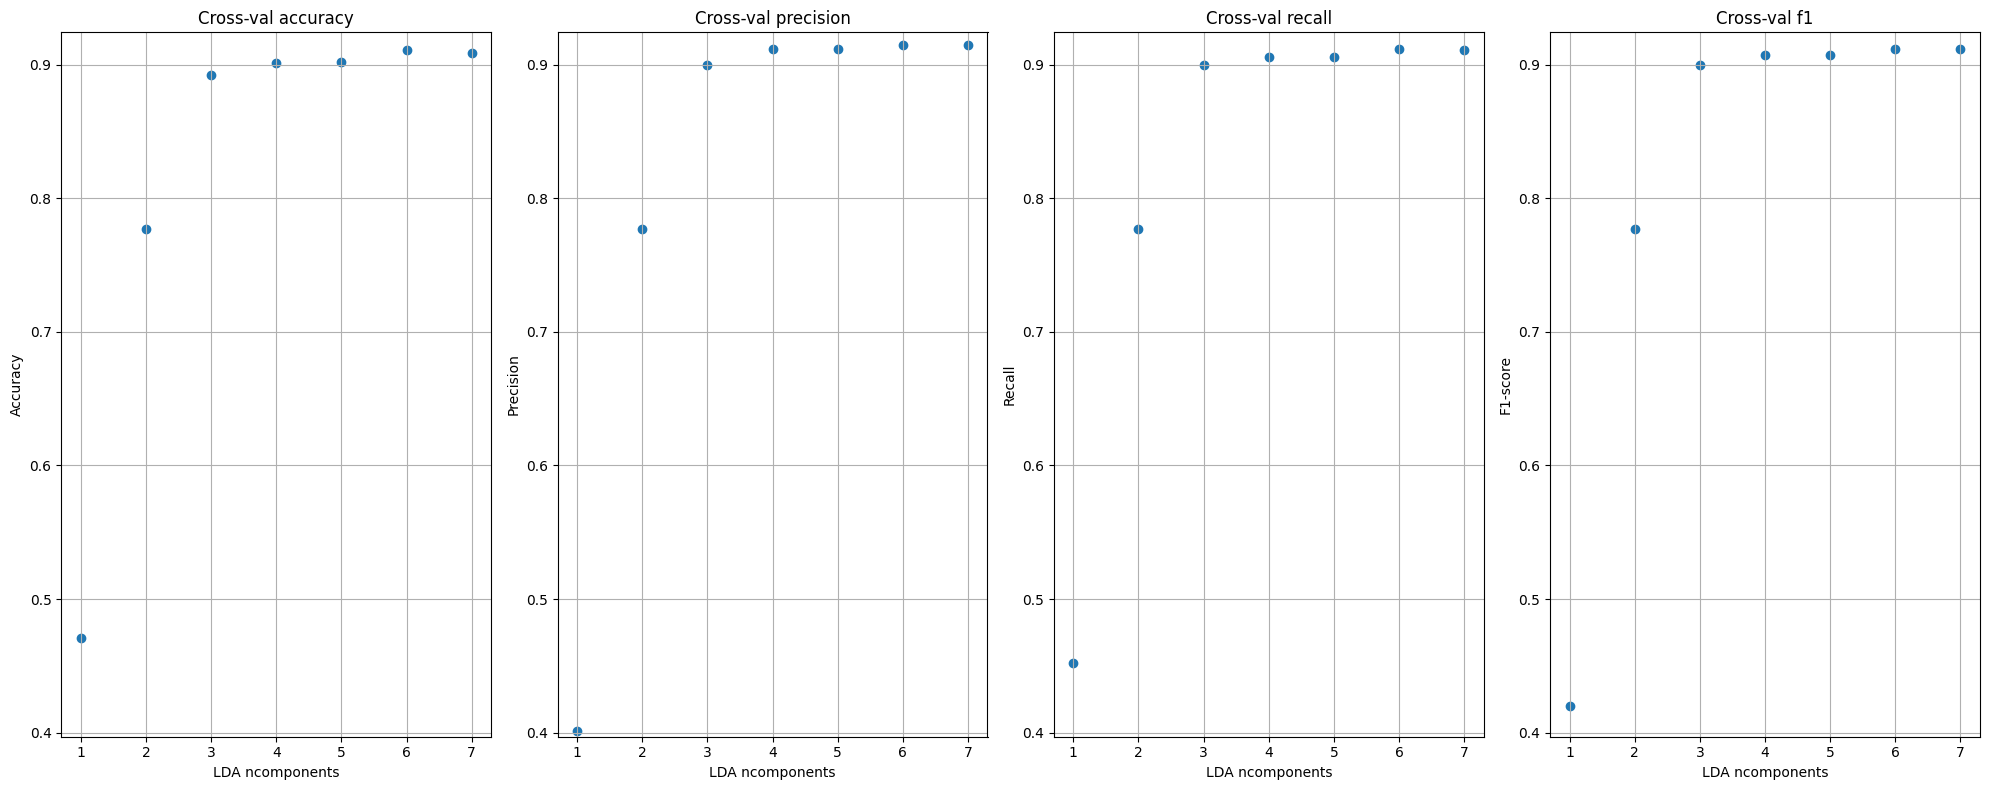

In [69]:
lda_gridsearch = pd.read_csv('./opt_ds_sift_lda_comp.csv', index_col=False)
plot_metrics(lda_gridsearch, 'LDA ncomponents')

### **Cross Validation**

In [70]:
#DenseSIFT, Nfeatures = 1500, Step size = 10, Spatial Pyramid level = 1, Codebook Size = 64
#Logistic Regression with solver = saga, max_iter = 20, C = 1
#LDA with 7 components
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid_sift,train_labels)

classifier = LogisticRegression(solver='saga', max_iter=20)
cv_scores = cross_validate(classifier, VWlda, 
                          train_labels,scoring = ['accuracy', 'precision_macro', 'recall_macro','f1_macro'], 
                          cv=10)

/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/adv

In [71]:
cross_validation_pd = pd.DataFrame.from_dict(cv_scores)
cross_validation_pd.round(4)

fit_time  score_time  test_accuracy  test_precision_macro  \
0    0.0092      0.0040         1.0000                1.0000   
1    0.0289      0.0167         1.0000                1.0000   
2    0.0759      0.0025         0.9947                0.9958   
3    0.0115      0.0018         1.0000                1.0000   
4    0.0107      0.0019         1.0000                1.0000   
5    0.0109      0.0019         1.0000                1.0000   
6    0.0113      0.0019         1.0000                1.0000   
7    0.0133      0.0019         1.0000                1.0000   
8    0.0127      0.0019         0.9947                0.9946   
9    0.0085      0.0018         0.9947                0.9952   

   test_recall_macro  test_f1_macro  
0             1.0000         1.0000  
1             1.0000         1.0000  
2             0.9950         0.9953  
3             1.0000         1.0000  
4             1.0000         1.0000  
5             1.0000         1.0000  
6             1.0000         1.0000  
7             1.0000         1.0000  
8             0.9950         0.9947  
9             0.9943         0.9946

In [72]:
print("%0.2f accuracy with a std dev of %0.2f" % (cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()))
print("%0.2f precision with a std dev of %0.2f" % (cv_scores['test_precision_macro'].mean(), cv_scores['test_precision_macro'].std()))
print("%0.2f recall with a std dev of %0.2f" % (cv_scores['test_recall_macro'].mean(), cv_scores['test_recall_macro'].std()))
print("%0.2f F1-score with a std dev of %0.2f" % (cv_scores['test_f1_macro'].mean(), cv_scores['test_f1_macro'].std()))

1.00 accuracy with a std dev of 0.00
1.00 precision with a std dev of 0.00
1.00 recall with a std dev of 0.00
1.00 F1-score with a std dev of 0.00


### **Test validation**

In [73]:
visual_words_test=np.zeros((len(test_images_filenames),visual_words_pyramid_sift.shape[1]),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    pyramid_des = spatial_pyramid(gray, SIFTdetector, level=1, dense=True, step_size=25)
    visual_words_test[i,:] = spatial_pyramid_histograms(pyramid_des, codebook_by_KMeans_random, k=256)

In [74]:
lda = LinearDiscriminantAnalysis(n_components=7)
VWlda = lda.fit_transform(visual_words_pyramid_sift,train_labels)

classifier = LogisticRegression(solver='saga')
classifier.fit(VWlda, train_labels)

vwtestlda = lda.transform(visual_words_test) 
test_lda_prediction = classifier.predict(vwtestlda)
test_lda_precision, test_lda_recall, test_lda_fscore, _ = precision_recall_fscore_support(test_labels, test_lda_prediction, average='macro')
test_lda_accuracy = classifier.score(vwtestlda, test_labels)

print("%0.2f accuracy" % (test_lda_accuracy))
print("%0.2f precision" % (test_lda_precision))
print("%0.2f recall" % (test_lda_recall))
print("%0.2f F1-score" % (test_lda_fscore))

0.66 accuracy
0.67 precision
0.67 recall
0.67 F1-score


/Users/advaitdixit/.virtualenvs/cv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### **Conclusions of random search experiment**
With the optimum parameters obtained by random search, the system is highly overfitted and the overall testing accuracy obtained is less than the one obtianed by Grid Search. It is interseting to see that the training accuracy is 1 which is not common for classification systems, so we are going with Grid Search technique for the rest of the experiments on this dataset.   

#### **Conclusions of the Week 1**

The classes which are difficult to predict for the model are also difficult to predict for humans. As we can see in most of the wrongly classified examples, they are wrong because they look very similar to the other classes visually, so it is not a surprise that the model has a difficulty in predicting them. The used dataset is tricky as well, as some classes contain other classes as elements. For example, an image of the class inside_city, might include the view of a street or tall buildings, which are classes themselves.